In [13]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
import logging
tf.get_logger().setLevel(logging.ERROR)

### Importing and Identifying data

In [14]:
test_data_dir = '../dataset/cats_dogs/test/'    # test_data_url
train_data_dir = '../dataset/cats_dogs/train/'  # training_data_url
image_shape = (224, 224)

In [15]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir, 
                                                         image_size=image_shape,
                                                         subset='training',
                                                         seed=42,
                                                         shuffle=True,
                                                         validation_split=0.1)
validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                              image_size=image_shape,
                                                              subset='validation',
                                                              seed=42,
                                                              shuffle=True,
                                                              validation_split=0.1)
test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir, 
                                                        image_size=image_shape)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [16]:
def plot_samples(dataset):
    for image,i in dataset.take(1):
        img = image
        lbl = i
    fig, ax = plt.subplots(4,4, figsize=(10,8))
    fig.suptitle("Cat and Dogs", fontsize=16)
    row = 0
    col = 0
    for i in range(16):
        ax[row, col].imshow(np.array(img[i]).astype(int))
        ax[row, col].set_title(np.array(lbl[i]))
        ax[row, col].axis('off')
        col +=1
        if col > 3:
            col=0
            row+=1

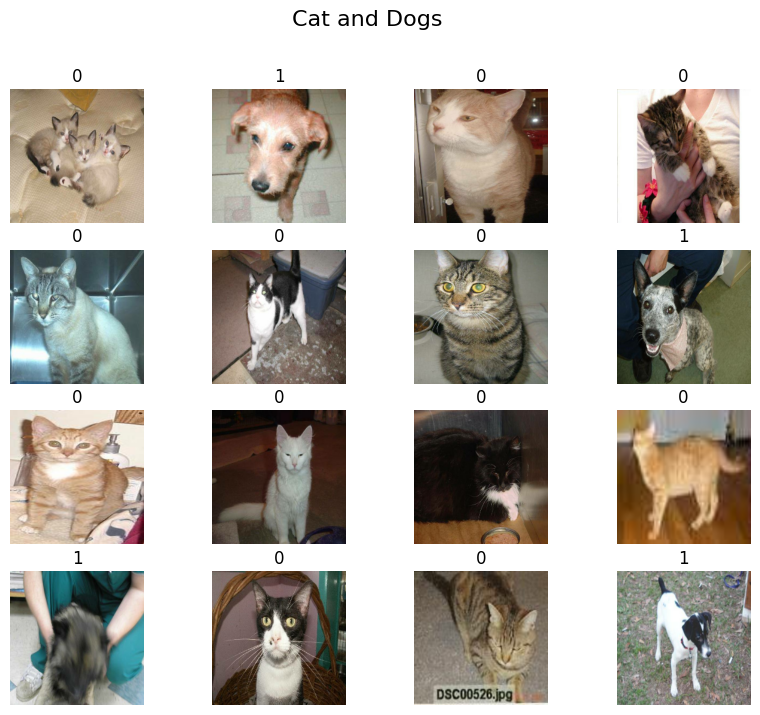

In [17]:
plot_samples(train_data)

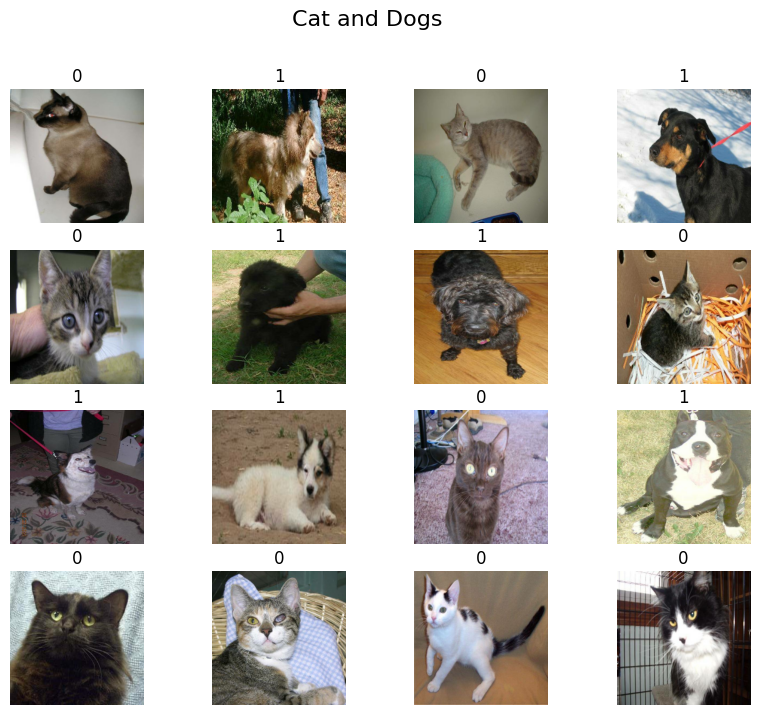

In [18]:
plot_samples(test_data)

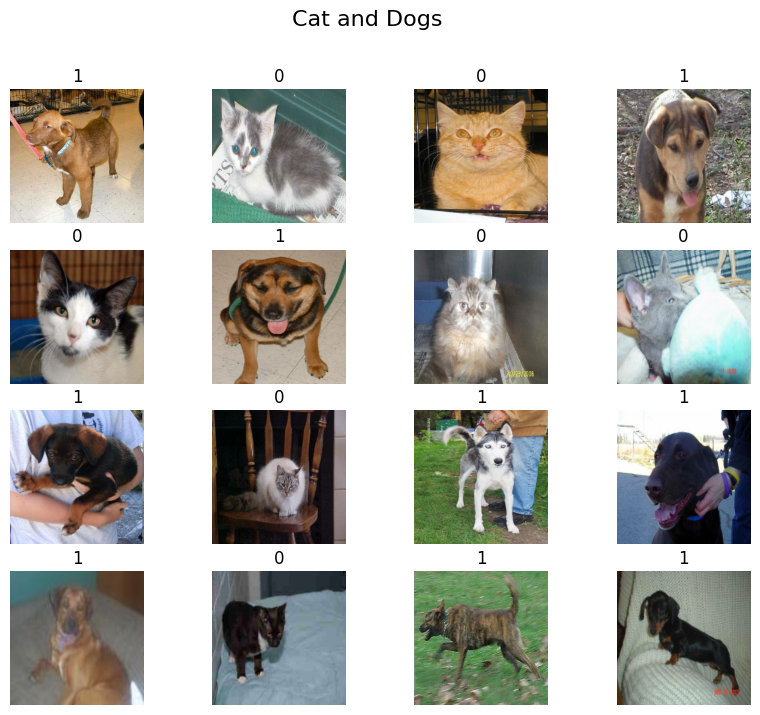

In [19]:
plot_samples(validation_data)

In [20]:
class_names = train_data.class_names   #cat = 0, dog = 1  

### Data Preprocessing

In [21]:
# data augmentation 
data_augmnetation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

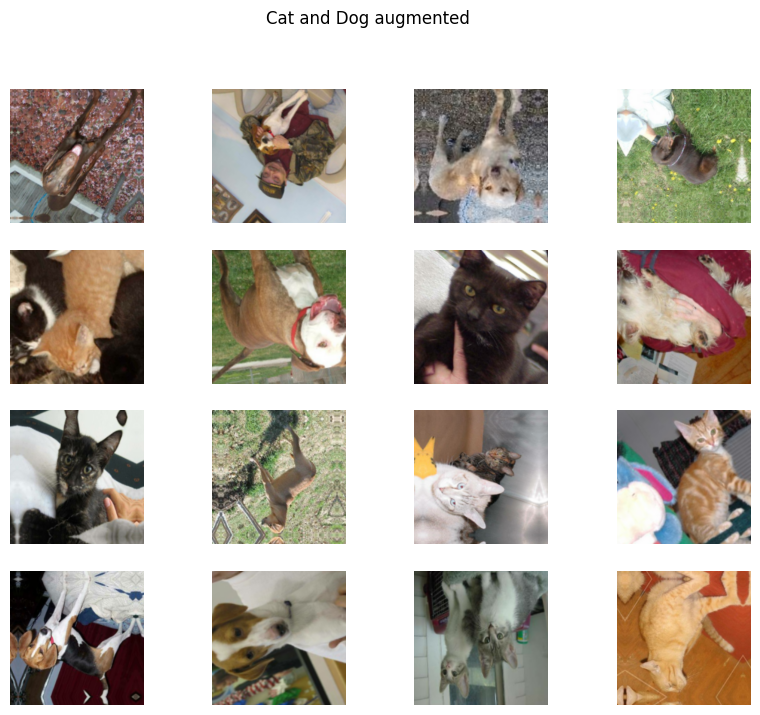

In [22]:
for image, label in train_data.take(5):
    augmented_images = data_augmnetation(image)

fig, ax = plt.subplots(4,4, figsize=(10,8))
fig.suptitle('Cat and Dog augmented')
col, row = 0,0
for i in range(16):
    ax[row, col].imshow(np.array(augmented_images[i]).astype(int))
    ax[row,col].axis('off')
    col+=1
    if col > 3:
        col = 0
        row += 1

In [23]:
train_data = train_data.map(lambda x, y: (data_augmnetation(x), y))

In [24]:
# data normalization
train_data = train_data.map(lambda x, y: (x/255, y))
validation_data = validation_data.map(lambda x, y: (x/255, y))
test_data = test_data.map(lambda x, y: (x/255, y))

### Modeling

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3,3),input_shape=(224,224,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [26]:
history=model.fit(train_data, 
          validation_data=validation_data,
          epochs=10)

Epoch 1/10
225/225 [==============================] - 119s 525ms/step - loss: 0.7173 - accuracy: 0.5810 - val_loss: 0.7142 - val_accuracy: 0.5075
Epoch 2/10
225/225 [==============================] - 115s 513ms/step - loss: 0.6398 - accuracy: 0.6331 - val_loss: 0.8484 - val_accuracy: 0.5188
Epoch 3/10
225/225 [==============================] - 113s 500ms/step - loss: 0.6246 - accuracy: 0.6449 - val_loss: 0.6121 - val_accuracy: 0.6587
Epoch 4/10
225/225 [==============================] - 114s 506ms/step - loss: 0.6039 - accuracy: 0.6724 - val_loss: 0.6337 - val_accuracy: 0.6312
Epoch 5/10
225/225 [==============================] - 119s 526ms/step - loss: 0.5889 - accuracy: 0.6797 - val_loss: 0.6617 - val_accuracy: 0.6400
Epoch 6/10
225/225 [==============================] - 116s 515ms/step - loss: 0.5846 - accuracy: 0.6933 - val_loss: 0.6315 - val_accuracy: 0.6575
Epoch 7/10
225/225 [==============================] - 109s 483ms/step - loss: 0.5668 - accuracy: 0.6972 - val_loss: 0.6635 -

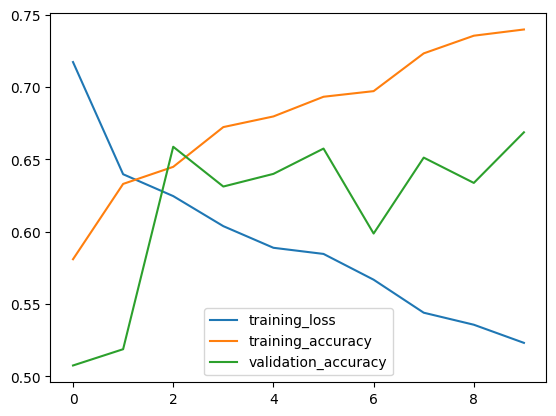

In [27]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.show()

In [28]:
test_img = '../dataset/cats_dogs/test/dogs/dog.4001.jpg'
with Image.open(test_img) as img:
    img = img.resize((224, 224))
    img = tf.keras.utils.img_to_array(img)
img = img/255

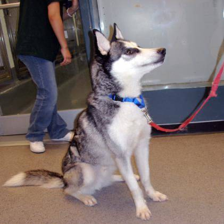

In [29]:
tf.keras.utils.array_to_img(img)

In [38]:
y_pred = model.predict(img.reshape(1,224,224,3))
y  = np.argmax(y_pred)

1/1 [==============================] - 0s 44ms/step


In [39]:
model.save('../dataset/models/cat_dog.h5')